In [1]:
from tqdm import tqdm
from IPython.display import display
import pandas as pd
import numpy as np
from collections import defaultdict
from utils import *
import os
from scipy.stats import ttest_ind
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tqdm.pandas()
def reverseEval(d):
    all_slots = defaultdict(list)
    new_set = [set() for _ in range(4)]
    for slots in d:
        for slot in slots:
            if slot[-2:] not in all_slots[slot[:-2]]:
                all_slots[slot[:-2]].append(slot[-2:])
    for i, slots in enumerate(d):
        for slot in slots:
            slot, index = slot[:-2], slot[-2:]
            new_set[i].add(slot+'_'+str(all_slots[slot].index(index)+1))
            
    return new_set

def plot_confusion_matrix(description, cm, classes,  cmap):
    plt.figure(figsize=(10, 10))

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(im,cax=cax)
    ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
    #          title=description,
         ylabel='True label',
         xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor",fontsize=12, fontweight='medium')
    plt.setp(ax.get_yticklabels(),fontsize=12, fontweight='medium')
    fmt = '.2f'

    thresh =cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
        
def getName(file):
    """
    Extracts name from file
    :param turn: file
    :return: name
    """
    name = ""
    name += 'Transformer ' if "TRAN" in file else "RNN " if "RNN" in file else ""
    name += "ALL" if "ALL" in file else "Vanilla" if "VAN" in file else "Role Based Entity" if name else ""
    return name if name else file[:-4]

## Training Graphs

In [17]:
allData = [(getName(file), "Results/logs/"+file) 
           for file in os.listdir("Results/logs")]

val_accuracy = defaultdict(lambda: [0])
val_perplexity = defaultdict(lambda: [0])
train_accuracy = defaultdict(lambda: [0])
train_perplexity = defaultdict(lambda: [0])
train_crossentropy = defaultdict(lambda: [0])

for name, dataFile in tqdm(allData):
    with open(dataFile, 'r') as file:
        lines = file.readlines()
        
    for line in lines:
        line_array = line.split()
        try:
            if line_array[3] == 'Start':
                steps = int(line_array[-2])
            elif line_array[3] == 'Step':
                acc, ppl, xent = [float(x[0]) for x in (line_array[6].split(';'), 
                                                     line_array[8].split(';'), 
                                                     line_array[10].split(';'))]
                train_accuracy[name].append(acc)
                train_perplexity[name].append(ppl)
                train_crossentropy[name].append(xent)
            elif line_array[3] == 'Validation':
                score = float(line_array[-1])
                if line_array[4] == 'perplexity:':
                    val_perplexity[name].append(score)
                else:
                    val_accuracy[name].append(score)
        except IndexError:
            pass
        
for name, data in [('Validation Accuracy', val_accuracy), ('Validation Perplexity', val_perplexity),
                   ('Train Accuracy', train_accuracy), ('Train Perplexity', train_perplexity),
                   ('Train Crossentropy', train_crossentropy), ]:
    table = pd.DataFrame.from_dict(data)
    table.insert(0, "Steps", [steps*i for i in range(len(data[list(data.keys())[0]]))])
    table.to_excel('Results/Analysis/{} Graph Data.xlsx'.format(name), index=False)
    display(name, table.head())
#         pd.DataFrame.from_dict({'Steps': [steps*i for i in range(1, len(val_accuracy)+1)], 'System Info': val_accuracy}).to_excel('testing.xlsx', index=False)

100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 259.65it/s]


'Validation Accuracy'

,Steps,RNN ALL,RnN_GLOVE_RBEI_log,RNN Role Based Entity,RNN Vanilla,Transformer ALL,Transformer Role Based Entity,Transformer Vanilla
0,0,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000
1,100,11.5744,12.74110,0.015564,0.147098,11.5744,15.2925,10.9922
2,200,12.0566,7.03174,11.579800,6.418830,32.6851,29.7138,17.1436
3,300,11.5744,10.06530,11.579800,0.000000,48.5376,44.7418,27.5207
4,400,12.2122,19.36840,11.579800,0.267451,53.7803,54.0604,39.0078


'Validation Perplexity'

,Steps,RNN ALL,RnN_GLOVE_RBEI_log,RNN Role Based Entity,RNN Vanilla,Transformer ALL,Transformer Role Based Entity,Transformer Vanilla
0,0,0.000,0.000,0.000,0.00,0.0000,0.0000,0.0000
1,100,2599.640,634.676,4587.760,20816.40,193.4270,261.6850,564.8200
2,200,534.343,410.205,604.194,2618.37,45.3321,55.3620,213.8510
3,300,486.683,153.967,593.692,1742.77,17.0728,20.8041,97.1547
4,400,311.721,131.978,289.432,1385.51,12.4534,12.4517,45.2554


'Train Accuracy'

,Steps,RNN ALL,RnN_GLOVE_RBEI_log,RNN Role Based Entity,RNN Vanilla,Transformer ALL,Transformer Role Based Entity,Transformer Vanilla
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100,2.57,2.31,2.43,1.70,6.20,7.60,6.82
2,200,4.49,4.74,3.49,1.91,11.99,12.60,10.81
3,300,4.90,5.95,4.66,2.88,14.38,14.11,11.18
4,400,5.80,7.65,5.79,3.84,27.59,21.70,12.14


'Train Perplexity'

,Steps,RNN ALL,RnN_GLOVE_RBEI_log,RNN Role Based Entity,RNN Vanilla,Transformer ALL,Transformer Role Based Entity,Transformer Vanilla
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100,13335127.58,436153.65,1605991.23,29022124.08,356.77,462.63,605.39
2,200,16857.26,8105.40,13751.02,572409.56,119.87,159.63,275.88
3,300,1501.39,967.64,1788.01,28090.71,66.89,86.72,190.18
4,400,748.74,514.92,701.34,8289.33,31.70,48.92,129.84


'Train Crossentropy'

,Steps,RNN ALL,RnN_GLOVE_RBEI_log,RNN Role Based Entity,RNN Vanilla,Transformer ALL,Transformer Role Based Entity,Transformer Vanilla
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100,16.41,12.99,14.29,17.18,5.88,6.14,6.41
2,200,9.73,9.00,9.53,13.26,4.79,5.07,5.62
3,300,7.31,6.87,7.49,10.24,4.20,4.46,5.25
4,400,6.62,6.24,6.55,9.02,3.46,3.89,4.87


In [16]:
print(len([steps*i for i in range(len(data[list(data.keys())[0]]))]))
[len(x) for x in val_accuracy.values()]

102


[101, 101, 101, 101, 101, 101, 101]

In [2]:
help(rolebased)
# rolebased(temp,slots[i], inplace=True, ordered=True)

Help on function rolebased in module utils:

rolebased(inputs, slots, del_unused=False, inplace=False, ordered=False)
    Does role based entity indexing on string
    :param inputs (array): array of texts
    :param slots (dictionary): dictionary of slots
    :param del_unused (boolean): flag to inticate if unused entities should be removed or not
    :param inplace (boolean): bool for return
    :param ordered (boolean): nool indicating if to maintain current slot ordering during index
    :return: array of texts replaced with entity indexes



## Evaluation scores

In [9]:
meanTable = defaultdict(list)
deviationTable = defaultdict(list)
BoxPlots = defaultdict(lambda: defaultdict(list))
allData = [(getName(file), "Results/Predictions/test/"+file) 
           for file in os.listdir("Results/Predictions/test")]
Beta = 1 # for F1 score 
evalDataTable = pd.read_json('Data/Evaluation/TEST EVAL Table.json') #'Data/Evaluation/TEST EVAL Table.json'
evalDataTable = evalDataTable.iloc[evalDataTable.index.argsort()]
slots = list(pd.read_json('Data/Table/TEST CQR Table.json').Slots)
slotIndexes  = evalDataTable.SlotIndex
evalDataTable.drop(columns=['SlotIndex'], inplace=True)
display(evalDataTable.head())

for name, dataFile in tqdm(allData):
    
    with open(dataFile, 'r') as file:
            predLines = file.readlines()
            
#     if "ALL" not in name and "Role Based Entity" not in name:
#         # function to extract entities from Vannila structure
#         temp = defaultdict(list)
#         newLines = []
#         for i, line in zip(slotIndexes, predLines):
#             temp[i].append(line.strip())
#         for i in sorted(list(temp.keys())):
#             rolebased(temp[i], slots[i], inplace=True, ordered=True)
#             newLines.extend(temp[i])
#         predLines = newLines

    evalTable = defaultdict(list)
#     c = 0
#     tests = []
    for i in range(len(predLines)):
        d = defaultdict(set)
        domain = evalDataTable.iloc[i][-1]
        d[0], d[1], d[2], d[3] = reverseEval(evalDataTable.iloc[i][:-1]) if 'Transformer' not in name else [set(x) for x in evalDataTable.iloc[i][:-1]]
#         for x in d[0]:
#             if '_1' not in x:
#                 tests.append([set(x) for x in evalDataTable.iloc[i]])
#                 c+=1
#                 break
        slots = d[0].union(d[1]).union(d[2]).union(d[3])
        new_d = {domain: slots}
        line = set(slotExtractor(predLines[i]))
        wrongSlots = len(line - (d[0].union(d[1]).union(d[2]).union(d[3])))
        d = new_d
        for _d, value in d.items():
            A_and_B = len(d[_d].intersection(line))
            precison = A_and_B / (A_and_B + wrongSlots) if A_and_B else 0 if d[_d] else np.nan
            recall = A_and_B / len(d[_d]) if A_and_B else 0 if d[_d] else np.nan
            f1_num = (1+Beta)*(precison*recall)
            f1_denum = recall + precison*Beta**2
            f1 = f1_num/f1_denum if precison and recall else 0 if d[_d] else np.nan
            evalTable['P '+str(_d)].append(precison)
            evalTable['R '+str(_d)].append(recall)
            evalTable['F1 '+str(_d)].append(f1)
#             if _d == 0 and precison != 1:
#                 display(i, evalDataTable.iloc[i], line)
#                 break
#     display(c, len(predLines))
#     sys.exit()       
    meanTable['Name'].append(name)
    deviationTable['Name'].append(name)

    for i in ['navigate', 'schedule', 'weather']:#range(4):
        usableIndex = np.array(evalTable['F1 '+str(i)]) == np.array(evalTable['F1 '+str(i)])
        for measure in ['P ', 'R ', 'F1 ']:
            mean = np.array(evalTable[measure+str(i)])[usableIndex].mean()
            std = np.array(evalTable[measure+str(i)])[usableIndex].std()
            meanTable[measure + str(i)].append(mean)
            deviationTable[measure + str(i)].append(std)
            BoxPlots[measure][name+" "+measure+str(i)].extend(evalTable[measure+str(i)])
pd.DataFrame.from_dict(meanTable).to_excel('Results/Analysis/PRF mean Table Reverse.xlsx',index=False)
# pd.DataFrame.from_dict(deviationTable).to_excel('Results/Analysis/PRF deviation Table.xlsx',index=False)
display(pd.DataFrame.from_dict(meanTable))
display(pd.DataFrame.from_dict(deviationTable))
for measure in ['P ', 'R ', 'F1 ']:
#     pd.DataFrame.from_dict(BoxPlots[measure]).to_excel('Results/Analysis/{}Table.xlsx'.format(measure),index=False)
    display(pd.DataFrame.from_dict(BoxPlots[measure]).head())

,0,1,2,3,Domain
0,[event_1],[],[],[],schedule
1,"[event_1, time_1]",[event_1],[event_1],[],schedule
2,[poi_type_1],[],[],[],navigate
3,"[distance_1, traffic_info_1]",[poi_1],[],[],navigate
4,[],[poi_1],[],[poi_1],navigate



100%|██████████████████████████████████████████████████████████████| 7/7 [01:22<00:00, 11.02s/it]

,Name,P navigate,R navigate,F1 navigate,P schedule,R schedule,F1 schedule,P weather,R weather,F1 weather
0,pred-10000-TEST,0.847318,0.906631,0.863270,0.915799,0.930556,0.917014,0.932927,0.981707,0.949042
1,pred-5000-TEST,0.833615,0.915531,0.857300,0.907118,0.931424,0.912153,0.920224,0.967480,0.935569
2,pred-6000-TEST,0.842686,0.914436,0.864538,0.906076,0.917535,0.902555,0.929878,0.984756,0.946719
3,pred-7000-TEST,0.844796,0.932027,0.872315,0.914583,0.948785,0.922603,0.934959,0.984756,0.951074
4,pred-8000-TEST,0.839703,0.919148,0.864904,0.912326,0.932292,0.914187,0.923780,0.977642,0.941928
5,pred-9000-TEST,0.863361,0.937432,0.885290,0.920660,0.950521,0.928307,0.929878,0.972561,0.940302
6,Transformer Role Based Entity,0.864577,0.903335,0.875126,0.946701,0.964410,0.950876,0.977642,0.977642,0.975203


,Name,P navigate,R navigate,F1 navigate,P schedule,R schedule,F1 schedule,P weather,R weather,F1 weather
0,pred-10000-TEST,0.244858,0.214940,0.219284,0.229323,0.226201,0.223466,0.176508,0.117869,0.142850
1,pred-5000-TEST,0.245025,0.208336,0.216507,0.232883,0.220149,0.222941,0.202531,0.161378,0.176015
2,pred-6000-TEST,0.237605,0.202602,0.208537,0.243089,0.245473,0.238971,0.173864,0.097067,0.136133
3,pred-7000-TEST,0.228934,0.177560,0.194191,0.200351,0.175697,0.180529,0.167439,0.097067,0.129934
4,pred-8000-TEST,0.240321,0.206055,0.212813,0.232728,0.219266,0.220789,0.194435,0.138376,0.163018
5,pred-9000-TEST,0.201465,0.151215,0.163286,0.195015,0.180654,0.181979,0.180554,0.140505,0.155569
6,Transformer Role Based Entity,0.246898,0.227125,0.229269,0.169569,0.149141,0.157567,0.128210,0.128210,0.128343


ValueError: arrays must all be same length

In [2]:
os.listdir('Data/Table')

['DEV CQR Table.json',
 'TEST CQR Table.json',
 'TRAIN CQR Table.json',
 'TREC CQR Table.json',
 'TREC+ CQR Table.json',
 'TREC++ CQR Table.json']

In [2]:
meanTable = defaultdict(list)
deviationTable = defaultdict(list)
BoxPlots = defaultdict(lambda: defaultdict(list))
allData = [(getName(file), "Results/Predictions/TREC/"+file) 
           for file in os.listdir("Results/Predictions/TREC")]
Beta = 1 # for F1 score 
# evalDataTable = pd.read_json('Data/Evaluation/TEST EVAL Table.json') #'Data/Evaluation/TEST EVAL Table.json'
# evalDataTable = evalDataTable.iloc[evalDataTable.index.argsort()]
# slots = list(pd.read_json('Data/Table/TEST CQR Table.json').Slots)
# slotIndexes  = evalDataTable.SlotIndex
# evalDataTable.drop(columns=['SlotIndex'], inplace=True)
# display(evalDataTable.head())

with open('Data/Model/TREC++_Entity_index_TEST_input.txt', 'r') as file:
    result_lines = file.readlines()
for name, dataFile in tqdm(allData):
    
    with open(dataFile, 'r') as file:
            predLines = file.readlines()
            
#     if "ALL" not in name and "Role Based Entity" not in name:
#         # function to extract entities from Vannila structure
#         temp = defaultdict(list)
#         newLines = []
#         for i, line in zip(slotIndexes, predLines):
#             temp[i].append(line.strip())
#         for i in sorted(list(temp.keys())):
#             rolebased(temp[i], slots[i], inplace=True, ordered=True)
#             newLines.extend(temp[i])
#         predLines = newLines

    evalTable = defaultdict(list)
#     c = 0
#     tests = []
    for i in range(len(predLines)):
        d = defaultdict(set)
#         domain = evalDataTable.iloc[i][-1]
#         d[0], d[1], d[2], d[3] = reverseEval(evalDataTable.iloc[i][:-1]) if 'Transformer' not in name else [set(x) for x in evalDataTable.iloc[i][:-1]]
#         for x in d[0]:
#             if '_1' not in x:
#                 tests.append([set(x) for x in evalDataTable.iloc[i]])
#                 c+=1
#                 break
#         slots = d[0].union(d[1]).union(d[2]).union(d[3])
        slots = set(slotExtractor(result_lines[i]))
        new_d = {'SEARCH': slots}
        line = set(slotExtractor(predLines[i]))
        wrongSlots = len(line - (d[0].union(d[1]).union(d[2]).union(d[3])))
        d = new_d
        for _d, value in d.items():
            A_and_B = len(d[_d].intersection(line))
            precison = A_and_B / (A_and_B + wrongSlots) if A_and_B else 0 if d[_d] else np.nan
            recall = A_and_B / len(d[_d]) if A_and_B else 0 if d[_d] else np.nan
            f1_num = (1+Beta)*(precison*recall)
            f1_denum = recall + precison*Beta**2
            f1 = f1_num/f1_denum if precison and recall else 0 if d[_d] else np.nan
            evalTable['P '+str(_d)].append(precison)
            evalTable['R '+str(_d)].append(recall)
            evalTable['F1 '+str(_d)].append(f1)
#             if _d == 0 and precison != 1:
#                 display(i, evalDataTable.iloc[i], line)
#                 break
#     display(c, len(predLines))
#     sys.exit()       
    meanTable['Name'].append(name)
    deviationTable['Name'].append(name)

    for i in ['navigate', 'schedule', 'weather', 'SEARCH'][3:]:#range(4):
        usableIndex = np.array(evalTable['F1 '+str(i)]) == np.array(evalTable['F1 '+str(i)])
        for measure in ['P ', 'R ', 'F1 ']:
            mean = np.array(evalTable[measure+str(i)])[usableIndex].mean()
            std = np.array(evalTable[measure+str(i)])[usableIndex].std()
            meanTable[measure + str(i)].append(mean)
            deviationTable[measure + str(i)].append(std)
            BoxPlots[measure][name+" "+measure+str(i)].extend(evalTable[measure+str(i)])
pd.DataFrame.from_dict(meanTable).to_excel('Results/Analysis/PRF mean Table Reverse.xlsx',index=False)
# pd.DataFrame.from_dict(deviationTable).to_excel('Results/Analysis/PRF deviation Table.xlsx',index=False)
display(pd.DataFrame.from_dict(meanTable))
display(pd.DataFrame.from_dict(deviationTable))
for measure in ['P ', 'R ', 'F1 ']:
#     pd.DataFrame.from_dict(BoxPlots[measure]).to_excel('Results/Analysis/{}Table.xlsx'.format(measure),index=False)
    display(pd.DataFrame.from_dict(BoxPlots[measure]).head())

100%|██████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.34s/it]


,Name,P SEARCH,R SEARCH,F1 SEARCH
0,Pred-Allen,0.275862,0.441667,0.326190
1,pred-Entity-8000-TEST,0.427469,0.632407,0.482187
2,pred-Entity-9000-TEST,0.429012,0.664506,0.496179
3,Pred-Neural,0.267241,0.433046,0.317570
4,pred-simple-8000-TEST,0.351852,0.532099,0.403880


,Name,P SEARCH,R SEARCH,F1 SEARCH
0,Pred-Allen,0.248659,0.450301,0.305830
1,pred-Entity-8000-TEST,0.169760,0.371744,0.217791
2,pred-Entity-9000-TEST,0.159093,0.354542,0.200536
3,Pred-Neural,0.249405,0.453873,0.307850
4,pred-simple-8000-TEST,0.228312,0.425811,0.280843


ValueError: arrays must all be same length

In [9]:
evalTable

defaultdict(list,
            {'P SEARCH': [nan,
              0.5,
              0.5,
              0,
              0,
              0.5,
              0.5,
              0.5,
              0.5,
              0,
              0.5,
              0.5,
              nan,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0,
              0,
              0.5,
              0,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0.5,
              0,
              0.5,
              0.5,
              0.5,
              0,
              0.5,
              0,
              nan,
              0,
              0.5,
              0.5,
              nan,
              nan,
              0,
              0,
              0,
              0.5,
              0.5,
              0.5,
              0.5,
              0,
              0,
            

783
Index(['Allen nlp F1 0', 'Copy turn F1 0', 'Neural coref F1 0', 'RNN ALL F1 0',
       'RNN Role Based Entity F1 0', 'RNN Vanilla F1 0',
       'Transformer ALL F1 0', 'Transformer Role Based Entity F1 0',
       'Transformer Vanilla F1 0'],
      dtype='object')
Index(['Allen nlp F1 1', 'Copy turn F1 1', 'Neural coref F1 1', 'RNN ALL F1 1',
       'RNN Role Based Entity F1 1', 'RNN Vanilla F1 1',
       'Transformer ALL F1 1', 'Transformer Role Based Entity F1 1',
       'Transformer Vanilla F1 1'],
      dtype='object')
Index(['Allen nlp F1 2', 'Copy turn F1 2', 'Neural coref F1 2', 'RNN ALL F1 2',
       'RNN Role Based Entity F1 2', 'RNN Vanilla F1 2',
       'Transformer ALL F1 2', 'Transformer Role Based Entity F1 2',
       'Transformer Vanilla F1 2'],
      dtype='object')
Index(['Allen nlp F1 3', 'Copy turn F1 3', 'Neural coref F1 3', 'RNN ALL F1 3',
       'RNN Role Based Entity F1 3', 'RNN Vanilla F1 3',
       'Transformer ALL F1 3', 'Transformer Role Based Entity F1 3'

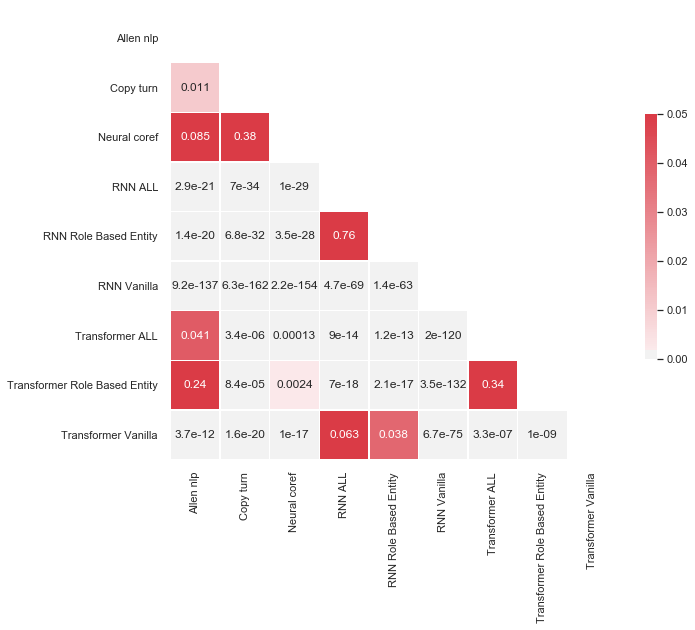

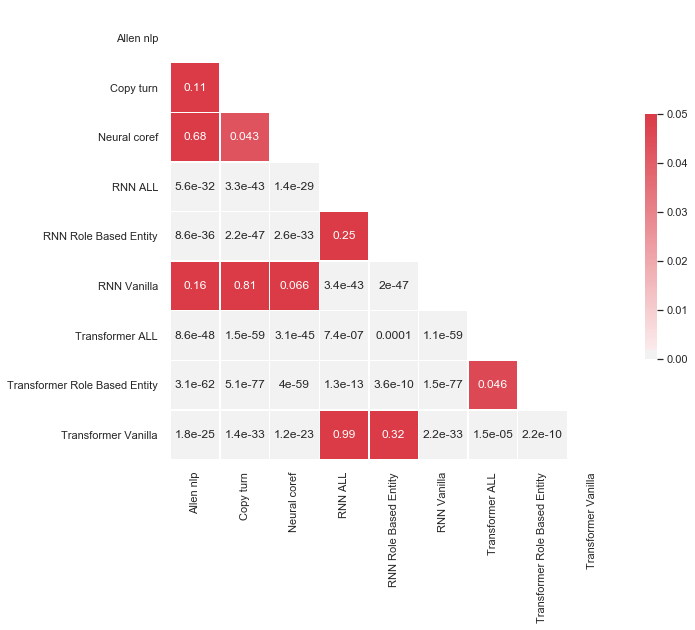

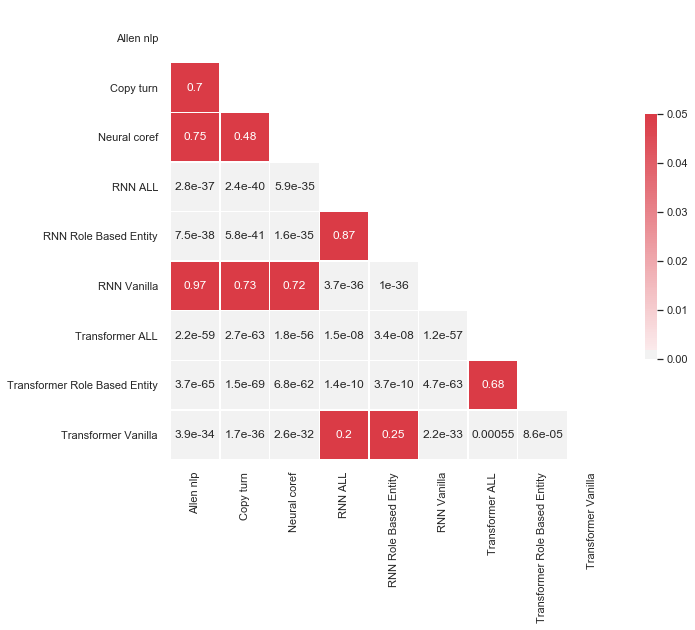

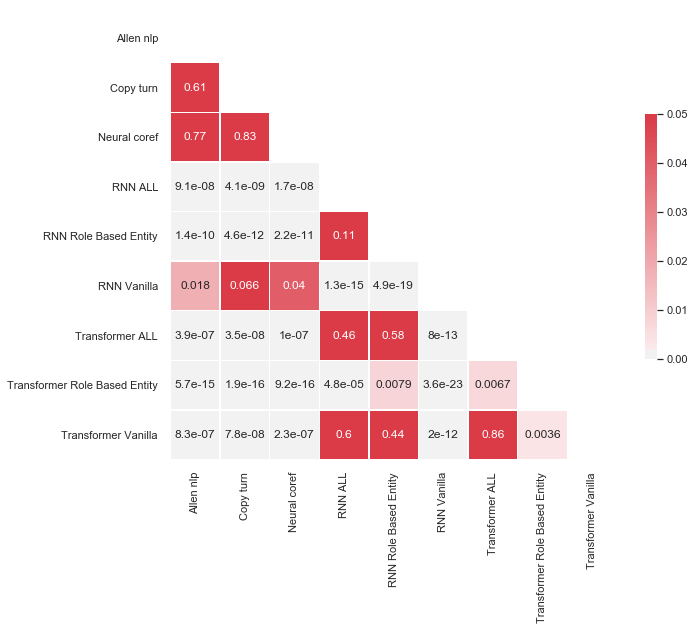

In [41]:
data = pd.read_excel('Results/Analysis/F1 Table.xlsx')
columns = data.columns
P_values = dict()
T_values = dict()
print(len(data))
for i in range(4):
    temp = data[[columns[j] for j in range(i, len(columns), 4)]].dropna()
    new_cols = temp.columns
    print(new_cols)
    size = len(new_cols)
    t = np.zeros((size, size))
    p = np.zeros((size, size))
    for k, col1 in enumerate(new_cols):
        for l, col2 in enumerate(new_cols):
            t[k][l], p[k][l] = ttest_ind(temp[col1], temp[col2])
    P_values[i] = p
    T_values[i] = t
    d = pd.DataFrame(data=p,
                     columns=[x[:-4] for x in new_cols])
    d.index = d.columns
    plotconfusion(d)
#     cm=p
#     classes=new_cols
#     cmap=plt.cm.Reds
#     description='Meh'
#     plot_confusion_matrix(description, cm, classes,  cmap)

In [40]:
def plotconfusion(data):
    sns.set(style="white")

    # Generate a large random dataset
#     rs = np.random.RandomState(33)
#     d = pd.DataFrame(data=rs.normal(size=(100, 10)),
#                      columns=list(ascii_letters[26:36]))

#     # Compute the correlation matrix
#     corr = d.corr()
#     corr.index = corr.index[::-1]
    # Generate a mask for the upper triangle
    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(data, mask=mask, cmap=cmap, vmax=.05, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [26]:
corr.index = corr.index[::-1]

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
def plot_confusion_matrix(description, cm, classes,  cmap):
    plt.figure(figsize=(10, 10))

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(im,cax=cax)
    ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
    #          title=description,
         ylabel='True label',
         xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor",fontsize=12, fontweight='medium')
    plt.setp(ax.get_yticklabels(),fontsize=12, fontweight='medium')
    fmt = '.2f'

    thresh =cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")

Index(['A', 'B'], dtype='object')

In [2]:
# table = pd.read_json('Data/Table/TREC++ CQR Table.json')
# slotsData = []
# for dialogslots in table.Slots:
#     temp = defaultdict(list)
#     slotset = set()
#     for slot_slottype in dialogslots:
#         for all_slots in [slotgenerator(x) for x in list(slot_slottype.items())]:
#             for slot in all_slots:
#                 if slot[1] not in slotset:
#                     slotset.add(slot[1])
#                     temp[slot[0]].append(slot[1])
# #                 print(slot)
#     slotsData.append(temp)
    
# index = []
# with open('Data/Model/TREC++_Entity_index_TEST_input.txt')as file:
#     data = file.readlines()
#     for line in data:
#         for dialog in
# os.listdir('Data/Model')

['DEV_ALL_D2T_input.txt',
 'DEV_COREF_D2T_input.txt',
 'DEV_Entity_index_input.txt',
 'DEV_RBEI_D2T_input.txt',
 'DEV_Reverse_RBEI_input.txt',
 'Output',
 'TEST_ALL_D2T_input.txt',
 'TEST_COREF_D2T_input.txt',
 'TEST_Entity_index_input.txt',
 'TEST_RBEI_D2T_input.txt',
 'TEST_Reverse_RBEI_input.txt',
 'TRAIN_ALL_D2T_input.txt',
 'TRAIN_COREF_D2T_input.txt',
 'TRAIN_Entity_index_input.txt',
 'TRAIN_RBEI_D2T_input.txt',
 'TRAIN_Reverse_RBEI_input.txt',
 'TREC++_Entity_index_input.txt',
 'TREC++_Entity_index_TEST_input.txt',
 'TREC++_Entity_index_TRAIN_input.txt',
 'TREC_input.txt',
 'TREC_Reverse_RBEI_input.txt',
 'TREC_TEST_input.txt',
 'TREC_TRAIN_input.txt',
 'TREC_TREC_Duplicates_input.txt',
 'TREC_TREC_input.txt',
 'TREC__input.txt']